Imports

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from textblob import TextBlob
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np


In [ ]:
import re
import random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model 
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Load Data


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data_ Suicidal Detection  - Sheet1.csv to Data_ Suicidal Detection  - Sheet1.csv


In [ ]:
dataset = pd.read_csv('Data_ Suicidal Detection  - Sheet1.csv')
dataset.head(5)

,Data #,Phrase,Suicidal of Not Suicidal
0,1,i hate myself so much i want to KILL myself how are y’all?!?! 🥴🥴,Potential Suicide post
1,2,"RT @DrugForumsBest: I woke up with a bag over my head after I intentionally overdosed on a conbo of 250 mg diclazepam, half a handle of bou…",Potential Suicide post
2,3,i wanna fucking kill myself,Potential Suicide post
3,4,"why do i destroy all my opportunities? am i going to kill myself on accident? if i only get worse, does that mean a… https://t.co/Ur1sapAyLo",Potential Suicide post
4,5,u - understand what the fuck im doing wrong with my life,Potential Suicide post


In [ ]:
#Load text and labels
train_text = pd.read_csv('Data_ Suicidal Detection  - Sheet1.csv', delimiter = "\t",header=None,names=["Text"])
train_labels = pd.read_csv('Data_ Suicidal Detection  - Sheet1.csv', delimiter = "\t",header=None,names=["Label"])

In [ ]:
#combine text and labels into one dataset
dataset = pd.concat([train_text,train_labels],axis=1)

In [ ]:
dataset.head(5)

,Text,Label
0,"Data #,Phrase,Suicidal of Not Suicidal","Data #,Phrase,Suicidal of Not Suicidal"
1,"1,i hate myself so much i want to KILL myself how are y’all?!?! 🥴🥴,Potential Suicide post","1,i hate myself so much i want to KILL myself how are y’all?!?! 🥴🥴,Potential Suicide post"
2,"2,""RT @DrugForumsBest: I woke up with a bag over my head after I intentionally overdosed on a conbo of 250 mg diclazepam, half a handle of bou…"",Potential Suicide post","2,""RT @DrugForumsBest: I woke up with a bag over my head after I intentionally overdosed on a conbo of 250 mg diclazepam, half a handle of bou…"",Potential Suicide post"
3,"3,i wanna fucking kill myself,Potential Suicide post","3,i wanna fucking kill myself,Potential Suicide post"
4,"4,""why do i destroy all my opportunities? am i going to kill myself on accident? if i only get worse, does that mean a… https://t.co/Ur1sapAyLo"",Potential Suicide post","4,""why do i destroy all my opportunities? am i going to kill myself on accident? if i only get worse, does that mean a… https://t.co/Ur1sapAyLo"",Potential Suicide post"


Generate tokens out of text

In [ ]:
#create an empty column to store the tokens
dataset["Tokens"] = None

In [ ]:
#generate tokens for each line of text
for ind in dataset.index:
    words = TextBlob(dataset["Text"][ind]).words
    # remove punctuation from each word
    words = [word for word in words if word.isalpha()]
    dataset["Tokens"][ind] = words

In [ ]:
dataset.tail(5)

,Text,Label,Tokens
1595,"1595,hi! just joined and i think it's brill! haha still in bed........couldn't be bothered getting up! anyway..........BYE!,Not Suicide post","1595,hi! just joined and i think it's brill! haha still in bed........couldn't be bothered getting up! anyway..........BYE!,Not Suicide post","[hi, just, joined, and, i, think, it, brill, haha, still, in, bed, could, be, bothered, getting, up, anyway, BYE, Not, Suicide, post]"
1596,"1596,@WilliamSledd Love the videos William New to twitter x,Not Suicide post","1596,@WilliamSledd Love the videos William New to twitter x,Not Suicide post","[WilliamSledd, Love, the, videos, William, New, to, twitter, x, Not, Suicide, post]"
1597,"1597,@itsanimesh I got an Openmoko FreeRunner and now and Android G1 as well!! yAy!,Not Suicide post","1597,@itsanimesh I got an Openmoko FreeRunner and now and Android G1 as well!! yAy!,Not Suicide post","[itsanimesh, I, got, an, Openmoko, FreeRunner, and, now, and, Android, as, well, yAy, Not, Suicide, post]"
1598,"1598,@PeoplemapsJulie I am looking for the berocca then all will be well,Not Suicide post","1598,@PeoplemapsJulie I am looking for the berocca then all will be well,Not Suicide post","[PeoplemapsJulie, I, am, looking, for, the, berocca, then, all, will, be, well, Not, Suicide, post]"
1599,"1599,""@mcherrywv pleasant is right thank u V8 ppl, ur the best!!!"",Not Suicide post","1599,""@mcherrywv pleasant is right thank u V8 ppl, ur the best!!!"",Not Suicide post","[mcherrywv, pleasant, is, right, thank, u, ppl, ur, the, best, Not, Suicide, post]"


Reduce each word to its root via lemmatization


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [ ]:
#create an empty column to store the cleaned words
dataset["Cleaned"] = None

In [ ]:
#generate tokens for each line of text
for ind in dataset.index:
    tokens = dataset["Tokens"][ind]
    cleaned_words = []
    for token in tokens:
        cleaned_words.append(lemmatizer.lemmatize(token))
    dataset["Cleaned"][ind] = cleaned_words

In [ ]:
dataset.tail(5)

,Text,Label,Tokens,Cleaned
1595,"1595,hi! just joined and i think it's brill! haha still in bed........couldn't be bothered getting up! anyway..........BYE!,Not Suicide post","1595,hi! just joined and i think it's brill! haha still in bed........couldn't be bothered getting up! anyway..........BYE!,Not Suicide post","[hi, just, joined, and, i, think, it, brill, haha, still, in, bed, could, be, bothered, getting, up, anyway, BYE, Not, Suicide, post]","[hi, just, joined, and, i, think, it, brill, haha, still, in, bed, could, be, bothered, getting, up, anyway, BYE, Not, Suicide, post]"
1596,"1596,@WilliamSledd Love the videos William New to twitter x,Not Suicide post","1596,@WilliamSledd Love the videos William New to twitter x,Not Suicide post","[WilliamSledd, Love, the, videos, William, New, to, twitter, x, Not, Suicide, post]","[WilliamSledd, Love, the, video, William, New, to, twitter, x, Not, Suicide, post]"
1597,"1597,@itsanimesh I got an Openmoko FreeRunner and now and Android G1 as well!! yAy!,Not Suicide post","1597,@itsanimesh I got an Openmoko FreeRunner and now and Android G1 as well!! yAy!,Not Suicide post","[itsanimesh, I, got, an, Openmoko, FreeRunner, and, now, and, Android, as, well, yAy, Not, Suicide, post]","[itsanimesh, I, got, an, Openmoko, FreeRunner, and, now, and, Android, a, well, yAy, Not, Suicide, post]"
1598,"1598,@PeoplemapsJulie I am looking for the berocca then all will be well,Not Suicide post","1598,@PeoplemapsJulie I am looking for the berocca then all will be well,Not Suicide post","[PeoplemapsJulie, I, am, looking, for, the, berocca, then, all, will, be, well, Not, Suicide, post]","[PeoplemapsJulie, I, am, looking, for, the, berocca, then, all, will, be, well, Not, Suicide, post]"
1599,"1599,""@mcherrywv pleasant is right thank u V8 ppl, ur the best!!!"",Not Suicide post","1599,""@mcherrywv pleasant is right thank u V8 ppl, ur the best!!!"",Not Suicide post","[mcherrywv, pleasant, is, right, thank, u, ppl, ur, the, best, Not, Suicide, post]","[mcherrywv, pleasant, is, right, thank, u, ppl, ur, the, best, Not, Suicide, post]"


Generate vector for classification

In [ ]:
#create sentences from stemmed tokens 
np_docs = []
for ind in dataset.index:
    res = ' '.join(dataset['Cleaned'][ind])
    np_docs.append(res)

In [ ]:
#fit tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10)
doc_vec = vectorizer.fit(np_docs)

In [ ]:
#create an empty column to store TFIDF
dataset["TFIDF"] = None

In [ ]:
for ind in dataset.index:
    dataset["TFIDF"][ind] = vectorizer.transform(dataset["Cleaned"][ind]).toarray()[0]

In [ ]:
dataset.head(2)

,Text,Label,Tokens,Cleaned,TFIDF
0,"Data #,Phrase,Suicidal of Not Suicidal","Data #,Phrase,Suicidal of Not Suicidal","[Data, Phrase, Suicidal, of, Not, Suicidal]","[Data, Phrase, Suicidal, of, Not, Suicidal]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,"1,i hate myself so much i want to KILL myself how are y’all?!?! 🥴🥴,Potential Suicide post","1,i hate myself so much i want to KILL myself how are y’all?!?! 🥴🥴,Potential Suicide post","[i, hate, myself, so, much, i, want, to, KILL, myself, how, are, y, all, Potential, Suicide, post]","[i, hate, myself, so, much, i, want, to, KILL, myself, how, are, y, all, Potential, Suicide, post]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


Log Regression Classifier

In [ ]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


In [ ]:
#gather features
features = []
for ind in dataset.index:
    features.append(dataset['TFIDF'][ind])

In [ ]:
#because we have only one feature   
for f in features:
    f = f.reshape(-1,1)

features[0].shape

(10,)

In [ ]:
labels = []
for ind in dataset.index:
    labels.append(dataset['Label'][ind])

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

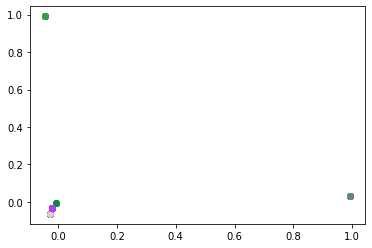

In [ ]:
pca = PCA(n_components=2).fit(features)
data2D = pca.transform(features)
x_coordinates = data2D[:,0]
y_coordinates =  data2D[:,1]
                
for x, y in zip(x_coordinates, y_coordinates):
    rgb = np.random.rand(3,)
    plt.scatter(x, y, c=[rgb])
plt.show()      

In [ ]:
#create train and test splits
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(features,labels,test_size=0.3)

In [ ]:
# function to prepare  input
def prepare_input(sample_text):
    words = TextBlob(sample_text).words
    # remove punctuation from each word
    words = [word for word in words if word.isalpha()]
    cleaned_words = []
    for word in words:
        cleaned_words.append(lemmatizer.lemmatize(word))
    return vectorizer.transform(cleaned_words).toarray()[0]

KNN MODEL 

In [ ]:
neigh_model = KNeighborsClassifier(n_neighbors=1)
neigh_model.fit(Train_X, Train_Y)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predictions_neigh = neigh_model.predict(Test_X)
print("Nearest Neighbors Accuracy Score -> ",accuracy_score(predictions_neigh, Test_Y)*50)

Nearest Neighbors Accuracy Score ->  0.0


In [ ]:
#insert test text here
test_text = "I am so excited for life and what's next"

In [ ]:
test_input = prepare_input(test_text).reshape(1, -1)
predicted_value = neigh_model.predict(test_input)[0]